In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, pickle 
import seaborn as sns
import cartopy.crs as ccrs
import scipy
import cartopy.feature as cfeature

def get_rmse(d1, d2):
    return ( np.nanmean( (d1-d2)**2 ) ) ** 0.5

def get_mae(d1, d2):
    return np.nanmean( np.abs(d1-d2))
        
def get_cc(d1, d2):
    ind = ~np.isnan(d1+d2)
    return np.corrcoef(d1[ind], d2[ind])[0,1]

def set_background(ax):
    ax.set_extent([-121, -72, 25, 50])

    # Background boundaries
    # ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    
    return ax



In [2]:
# load info
infile_basin_info = f"/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv"
df_info = pd.read_csv(infile_basin_info)

In [32]:
outfile = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/LSE_spaceCV_PredictParam/LSE_spaceCV_10trial_KGE.csv'

if os.path.isfile(outfile):
    df_kge_all = pd.read_csv(outfile)

else:
    
    bn = 627
    kge_all = np.nan * np.zeros([bn, 4])
    
    for b in range(bn):
        kgecv = np.nan * np.zeros(10)
        for t in range(10):
            file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{b}_MOASMOcalib/ctsm_outputs_LSEspaceCV/iter1_trial{t}/evaluation_many_metrics.csv'
            if os.path.isfile(file):
                dft = pd.read_csv(file)
                kgecv[t] = dft['kge'].values[0]

        file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{b}_MOASMOcalib/param_sets_LSEspaceCV/ga_output_iter1.npz'
        d = np.load(file)
        indcvmax = np.nanargmax(d['ga_all_outputs'])
        
        kgelse = np.nan * np.zeros(10)
        for t in range(10):
            file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{b}_MOASMOcalib/ctsm_outputs_emutest/iter1_trial{t}/evaluation_many_metrics.csv'
            if os.path.isfile(file):
                dft = pd.read_csv(file)
                kgelse[t] = dft['kge'].values[0]

        kgesse = np.nan * np.zeros(10)
        for t in range(10):
            file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{b}_MOASMOcalib/ctsm_outputs_normKGE/iter1_trial{t}/evaluation_many_metrics.csv'
            if os.path.isfile(file):
                dft = pd.read_csv(file)
                kgesse[t] = dft['kge'].values[0]
        
        file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{b}_MOASMOcalib/ctsm_outputs/iter0_trial0/evaluation_many_metrics.csv'
        dft = pd.read_csv(file)
        kgedefa = dft['kge'].values[0]


        kge_all[b, 0] = kgedefa
        kge_all[b, 1] = np.nanmedian(kgesse)
        kge_all[b, 2] = np.nanmedian(kgelse)
        kge_all[b, 3] = np.nanmedian(kgecv)
        
        # kge_all[b, 1] = np.nanmax(kgesse)
        # kge_all[b, 2] = np.nanmax(kgelse)
        # # kge_all[b, 3] = np.nanmax(kgecv)
        # kge_all[b, 3] = kgecv[indcvmax]
    
    df_kge_all = pd.DataFrame(kge_all, columns=['Defa', 'SSE', 'LSE_all', 'LSE_CV'])
    df_kge_all.to_csv(outfile, index=False)

print('nan values', np.sum(np.isnan(df_kge_all.values), axis=0))

nan values [0 0 0 0]


In [33]:
# get iter-0 metrics

outfile = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/LSE_spaceCV_PredictParam/camels_iter0_KGE.npz'
if os.path.isfile(outfile):
    met_iter0 = np.load(outfile)['met_iter0']
else:
    
    met_iter0 = np.nan * np.zeros([627, 400])    
    for b in range (627):
        file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{b}_MOASMOcalib/ctsm_outputs/iter0_many_metric.csv'
        met_iter0[b,:] = pd.read_csv(file)['kge'].values
    np.savez_compressed(outfile, met_iter0=met_iter0)

df_kge_all['Iter0-M'] = np.nanmedian(met_iter0[:,1:], axis=1) # no defa included
df_kge_all = df_kge_all[['Defa', 'Iter0-M', 'SSE', 'LSE_all', 'LSE_CV']]

In [34]:
print('SSE > Defa', np.sum(df_kge_all['SSE'].values>df_kge_all['Defa'].values) / len(df_kge_all) )
print('LSE_all > Defa', np.sum(df_kge_all['LSE_all'].values>df_kge_all['Defa'].values) / len(df_kge_all) )
print('LSE_CV > Defa', np.sum(df_kge_all['LSE_CV'].values>df_kge_all['Defa'].values) / len(df_kge_all) )
print('Iter0 > Defa', np.sum(df_kge_all['Iter0-M'].values>df_kge_all['Defa'].values) / len(df_kge_all) )

SSE > Defa 0.8835725677830941
LSE_all > Defa 0.9569377990430622
LSE_CV > Defa 0.7575757575757576
Iter0 > Defa 0.2966507177033493


In [35]:
# print(df_kge_all.columns)
# print(np.nanmedian(df_kge_all, axis=0))
# plt.plot(kge_all)
# plt.legend(df_kge_all.columns)

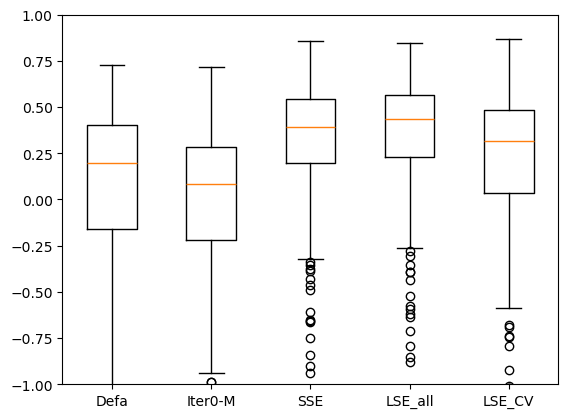

In [36]:
plt.boxplot(df_kge_all)
plt.xticks(np.arange(1, 6), df_kge_all.columns)
plt.ylim(-1, 1)

plt.show()

# final figure

Text(0, 0.5, 'KGE Score')

/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


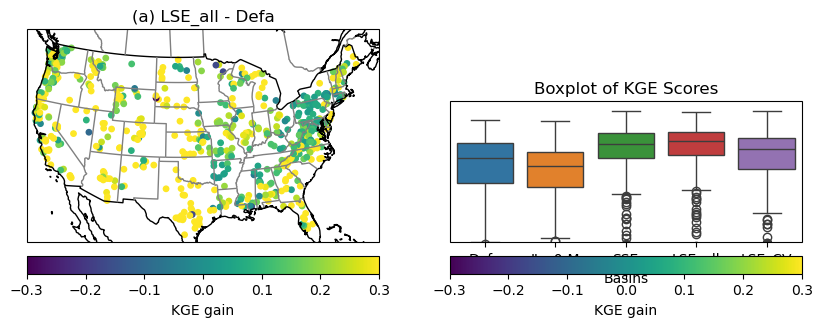

In [79]:


fig = plt.figure(figsize=[10, 8])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

dplot = [df_kge_all['LSE_all'].values - df_kge_all['Defa'].values, df_kge_all['LSE_CV'].values - df_kge_all['Defa'].values]
title = ['(a) LSE_all - Defa', '(b) LSE_CV - Defa']

for i in range(2):
    ax = fig.add_subplot(2, 2, i+1, projection=proj)
    ax = set_background(ax)
    p = ax.scatter(lon, lat, 15, dplot[i],  vmin = -0.3, vmax=0.3, transform=transf)
    ax.set_title(title[i])
    
    cax = plt.colorbar(p, ax=ax, location='bottom', shrink=1, label="KGE gain", pad=0.05)
    cax.ax.yaxis.set_ticks_position('right')
    cax.ax.yaxis.set_label_position('left')


sns.boxplot(data=df_kge_all)

# Customize the plot
plt.xticks(np.arange(len(df_kge_all.columns)), df_kge_all.columns)
plt.ylim(-1, 1)
plt.title('Boxplot of KGE Scores')
plt.xlabel('Basins')
plt.ylabel('KGE Score')


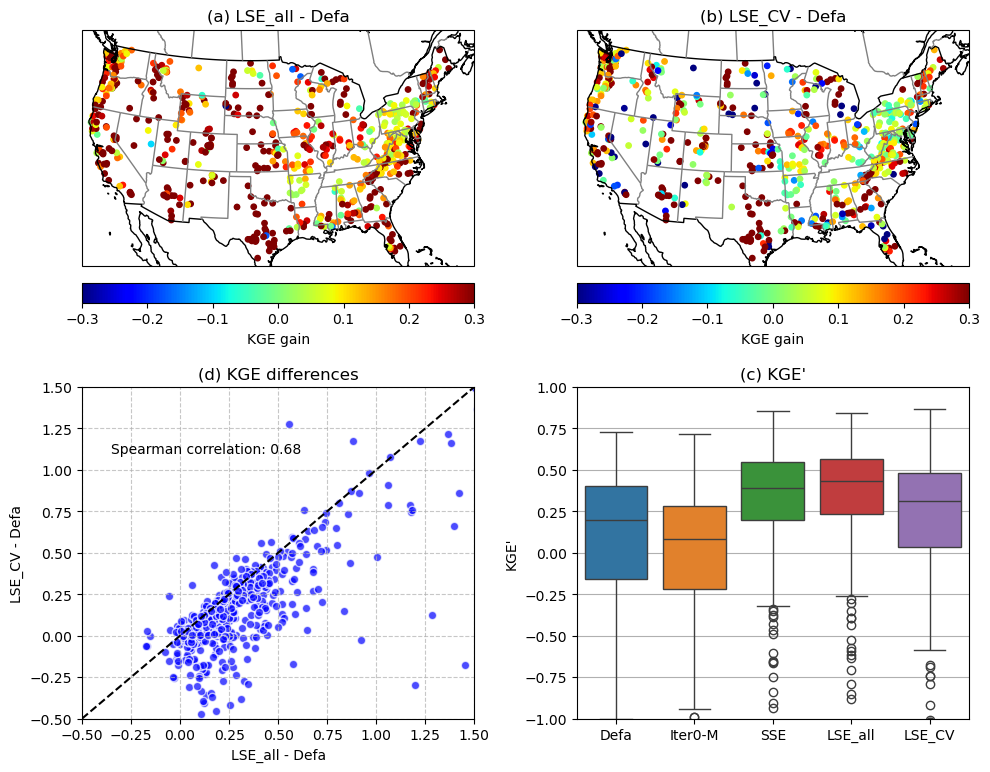

In [37]:
# LSE improvement against 

fig = plt.figure(figsize=[10, 8])

lon = df_info['lon_cen'].values
lat = df_info['lat_cen'].values
dplot = [df_kge_all['LSE_all'].values - df_kge_all['Defa'].values, df_kge_all['LSE_CV'].values - df_kge_all['Defa'].values]
title = ['(a) LSE_all - Defa', '(b) LSE_CV - Defa']

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

for i in range(2):
    ax = fig.add_subplot(2, 2, i+1, projection=proj)
    ax = set_background(ax)
    p = ax.scatter(lon, lat, 15, dplot[i],  vmin = -0.3, vmax = 0.3, transform=transf, cmap='jet')
    ax.set_title(title[i])
    
    cax = plt.colorbar(p, ax=ax, location='bottom', shrink=1, label="KGE gain", pad=0.05)
    cax.ax.yaxis.set_ticks_position('right')
    cax.ax.yaxis.set_label_position('left')


fig.add_subplot(2, 2, 3)
plt.scatter(dplot[0], dplot[1], c='b', edgecolor='w', alpha=0.7)  # Improved scatter plot
plt.plot([-0.5, 1.5], [-0.5, 1.5], 'k--')  # Dashed line for better visibility
plt.ylim(-0.5, 1.5)
plt.xlim(-0.5, 1.5)
plt.title("(d) KGE differences")  # Enhanced title
plt.ylabel("LSE_CV - Defa", fontsize=10)  # Enhanced labels
plt.xlabel('LSE_all - Defa', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)  # Improved grid with dashed lines and some transparency

scc = scipy.stats.spearmanr(dplot[0], dplot[1]).statistic
plt.text(-0.35, 1.1, f'Spearman correlation: {scc:.2f}')


fig.add_subplot(2, 2, 4)
sns.boxplot(data=df_kge_all)
plt.xticks(np.arange(len(df_kge_all.columns)), df_kge_all.columns)
plt.ylim(-1, 1)
plt.title("(c) KGE'")
plt.ylabel("KGE'")
plt.grid(axis='y')


plt.tight_layout()
# plt.savefig('LSE_spaceCV_minusDefa_AllInOne.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

In [21]:
print(df_kge_all.columns)
print(np.nanmedian(df_kge_all, axis=0))
print(np.nanmean(df_kge_all, axis=0))
print(np.nanpercentile(df_kge_all, 25, axis=0))
print(np.nanpercentile(df_kge_all, 75, axis=0))

Index(['Defa', 'Iter0-M', 'SSE', 'LSE_all', 'LSE_CV'], dtype='object')
[0.19520327 0.08050818 0.39334214 0.43499271 0.31473828]
[-1.21288643 -0.49649212  0.29835051  0.3370642  -0.08112757]
[-0.16088354 -0.21883861  0.19549535  0.23090507  0.03247075]
[0.40432882 0.28190309 0.54499238 0.56428862 0.48283697]


## the correlation with CV emiulator performance

In [81]:

met = np.nan * np.zeros([len(df_info), 3]) # rmse/cc/mae
for i in range(5):
    filei = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/LSE_spaceCV_PredictParam/RF_emulator_for_iter1_CVFold{i}_eval.npz'
    di = np.load(filei)
    y_test_pred=di['y_test_pred']
    y_test=np.squeeze(di['y_test'])
    basin_id=di['basin_id']

    for j in np.unique(basin_id):
        indj = basin_id == j
        met[j, 0] = get_rmse(y_test_pred[indj], y_test[indj])
        met[j, 1] = get_cc(y_test_pred[indj], y_test[indj])
        met[j, 2] = get_mae(y_test_pred[indj], y_test[indj])

print(np.sum(np.isnan(met), axis=0))

[0 0 0]


In [82]:
for i in range(3):
    print(scipy.stats.spearmanr(kge_all[:,1]-kge_all[:,0], met[:,i]))
    print(scipy.stats.spearmanr(kge_all[:,2]-kge_all[:,0], met[:,i]))

SignificanceResult(statistic=0.4235076801263896, pvalue=1.1137056200428028e-28)
SignificanceResult(statistic=0.39794034722270233, pvalue=3.1838510035980184e-25)
SignificanceResult(statistic=-0.08576127341409628, pvalue=0.03178281727535712)
SignificanceResult(statistic=-0.05087148405783611, pvalue=0.20333679492409198)
SignificanceResult(statistic=0.3971908196207983, pvalue=3.9794556366648814e-25)
SignificanceResult(statistic=0.3757667249665035, pvalue=1.8448192204360518e-22)


In [83]:
for i in range(3):
    print(scipy.stats.spearmanr(kge_all[:,1], met[:,i]))
    print(scipy.stats.spearmanr(kge_all[:,2], met[:,i]))

SignificanceResult(statistic=-0.09188869563794994, pvalue=0.0213820886997131)
SignificanceResult(statistic=-0.12684221139268323, pvalue=0.0014593349912523522)
SignificanceResult(statistic=0.13442983957207796, pvalue=0.0007388769617355284)
SignificanceResult(statistic=0.19068691020828749, pvalue=1.5133485507200736e-06)
SignificanceResult(statistic=-0.08510896629939685, pvalue=0.03311052972768608)
SignificanceResult(statistic=-0.1134586453646859, pvalue=0.004447812869090128)
